# Lab 3

## Набор данных

In [2]:
import pandas as pd

df = pd.read_csv('data/diabetes_dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Разделение на выборки и нормализация

In [3]:
df['Outcome'] = df['Outcome'].replace(to_replace=0, value=-1)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = df['Outcome']
X = df.drop(columns=['Outcome'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [5]:
def minmax(x, min, max):
    return (float(x) - min) / (max - min)

In [6]:
def normalize(X_train, X_test):
    for category in df.columns:
        if category == 'Outcome':
            continue

        col_train_min = X_train[category].min()
        col_train_max = X_train[category].max()

        col_test_min = X_test[category].min()
        col_test_max = X_test[category].max()
        
        X_train[category] = X_train[category].apply(lambda x: minmax(x, col_train_min, col_train_max))
        X_test[category] = X_test[category].apply(lambda x: minmax(x, col_test_min, col_test_max))

In [7]:
normalize(X_train, X_test)

In [8]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
542,0.714286,0.454545,0.772727,0.323232,0.000000,0.520119,0.317209,0.583333
589,0.000000,0.368687,0.000000,0.000000,0.000000,0.314456,0.110445,0.066667
439,0.428571,0.540404,0.800000,0.000000,0.000000,0.548435,0.275257,0.166667
173,0.071429,0.398990,0.545455,0.424242,0.056738,0.648286,0.254281,0.033333
51,0.071429,0.510101,0.454545,0.151515,0.042553,0.360656,0.189212,0.083333


## Алгоритмы

### Линейная регрессия с гребневой регуляризацией

Формула: $f(x,\theta)=\theta_0+\sum\limits_{i=1}^n{\theta_i x_i}$

Эмпирический риск: $L_\tau(\theta)=||F\theta-y||^2+\frac{1}{2\sigma}||\theta||^2\to\min$

Условие минимума: $\theta_\tau^*=(F^TF+\tau I_n)^{-1}F^Ty$

In [9]:
import numpy as np

class RidgeLinearRegression:
    def __init__(self, tau=1.0):
        self.tau = tau
        self.theta = None

    def fit(self, X, y):
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        I = np.eye(X.shape[1])
        I[0, 0] = 0

        self.theta = np.linalg.inv(X.T @ X + self.tau * I) @ X.T @ y

    def predict(self, X):
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        return X @ self.theta


### Преобразование алгоритма для задачи классификации

Для этого нужно изменить целевой признак на -1 и +1

In [10]:
import numpy as np

class RidgeLinearClassifier:
    def __init__(self, tau=1.0):
        self.regression = RidgeLinearRegression(tau=tau)
    
    def fit(self, X, y):
        y = np.where(y >= 0, 1, -1)
        self.regression.fit(X, y)

    def predict(self, X):
        predict = self.regression.predict(X)
        return np.where(predict >= 0, 1, 0)

### Линейный классификатор с градиентным спуском

#### Функции потерь

In [11]:
import numpy as np

class Loss:
    @staticmethod
    def get_by_name(name):
        if name == 'logarithmic':
            return Loss.logarithmic
        elif name == 'sigmoid':
            return Loss.sigmoid
        else:
            return Loss.exponential

    # Функции потери
    @staticmethod
    def logarithmic(margin):
        return np.log(1 + np.exp(-margin)), Loss.logarithmic_d(margin)
    
    @staticmethod
    def sigmoid(margin):
        return 1 / (1 + np.exp(margin)), Loss.sigmoid_d(margin)
    
    @staticmethod
    def exponential(margin):
        return np.exp(-margin), Loss.exponential_d(margin)
    
    # Производные функций потери
    @staticmethod
    def logarithmic_d(margin):
        return -1 / (np.exp(margin) + 1)
    
    @staticmethod
    def sigmoid_d(margin):
        return -np.exp(margin) / ((1 + np.exp(margin)) ** 2)
    
    @staticmethod
    def exponential_d(margin):
        return -np.exp(-margin)

#### Классификатор

$w_{(k+1)}=w_{(k)} - \mu\bigg(\frac{1}{|D|}\sum\limits_{i=1}^{|D|}{\big[L'((\langle w, x_i\rangle + b) y_i)x_i y_i}\big] + \lambda_1sign(w) + 2\lambda_2w\bigg)$

In [12]:
from sklearn.metrics import accuracy_score
import numpy as np

class GradientLinearClassifier:
    def __init__(self, loss=Loss.exponential, mu=0.01, lambda1=0.1, lambda2=0.1, max_iter=1000):
        self.loss = loss
        self.mu = mu
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.b = 0
        self.max_iter = max_iter

    def _compute_gradients(self, X, y):
        y_pred = np.dot(X, self.w) + self.b
        margins = y_pred * y

        losses, losses_d = self.loss(margins)

        grad_w = np.zeros(self.n_features)
        for i in range(self.n_features):
            grad_w[i] = np.mean(losses_d * X[:, i] * y)
            grad_w[i] += self.lambda1 * np.sign(self.w[i]) + 2 * self.lambda2 * self.w[i]
        
        grad_b = np.mean(losses_d * y)

        l1_reg = self.lambda1 * np.sum(np.abs(self.w))
        l2_reg = self.lambda2 * np.sum(self.w ** 2)
        empirical_risk = np.sum(losses) + l1_reg + l2_reg

        return grad_w, grad_b, empirical_risk
    
    def _compute_accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_pred, y_test)
    
    def get_emprical_risks(self):
        return self.empirical_risks
    
    def get_accuracies(self):
        return self.accuracies

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.n_samples, self.n_features = X_train.shape
        self.empirical_risks = []
        self.accuracies = []

        self.w = np.zeros(self.n_features)

        for iter in range(self.max_iter):
            grad_w, grad_b, risk = self._compute_gradients(X_train, y_train)
            self.w -= self.mu * grad_w
            self.b -= self.mu * grad_b
            self.empirical_risks.append(risk)
            
            if iter % 500 == 0 and X_test is not None and y_test is not None:
                self.accuracies.append(self._compute_accuracy(X_test, y_test))
        
        if X_test is not None and y_test is not None:
            self.accuracies.append(self._compute_accuracy(X_test, y_test))

    
    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

### Метод опорных векторов

#### Ядра

In [13]:
class Kernel:
    @staticmethod
    def get_from_name(name, gamma=None, c=0, degree=3):
        if name == 'linear':
            return lambda X, *args: Kernel.linear(X, *args)
        elif name == 'rbf':
            return lambda X, *args: Kernel.rbf(X, *args, gamma=gamma)
        elif name == 'polynomial':
            return lambda X, *args: Kernel.polynomial(X, *args, c=c, degree=degree)

    @staticmethod
    def linear(X, *args):
        if len(args) == 0:
            return np.dot(X, X.T)
        else:
            return np.dot(X, args[0])
        
    @staticmethod
    def rbf(X, *args, gamma=None):
        if len(args) == 0:
            return Kernel.rbf(X, X.T)
        
        X1 = np.atleast_2d(X)
        X2 = np.atleast_2d(args[0]).T

        if gamma is None:
            gamma = 1 / X1.shape[1]

        if X1.shape[0] == 1 and X2.shape[0] == 1:
            return np.exp(-gamma * np.linalg.norm(X1 - X2) ** 2)
        elif X1.shape[0] == 1 or X2.shape[0] == 1:
            if X1.shape[0] == 1:
                distances = np.linalg.norm(X2 - X1, axis=1) ** 2 
            else:
                distances = np.linalg.norm(X1 - X2, axis=1) ** 2 
            return np.exp(-gamma * distances)
        else:
            X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
            X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
            cross_term = np.dot(X1, X2.T)
            distances = X1_sq - 2 * cross_term + X2_sq
            return np.exp(-gamma * distances)

    @staticmethod
    def polynomial(X, *args, c=0.0, degree=3):
        if len(args) == 0:
            return (np.dot(X, X.T) + c) ** degree
        else:
            return (np.dot(X, args[0]) + c) ** degree

#### Алгоритм

Эмпирический риск: $L(a) = \sum\limits_{i=1}^{N}{(1-M_i(w, w_0))}_+ + \frac{1}{2C}||w||^2$

Двойственная задача: $-L(a) = -\sum\limits_{i=1}^{|D|}{\alpha_i} + 1/2\sum\limits_{i=1}^{|D|}\sum\limits_{j=1}^{|D|}{\alpha_i\alpha_jy_iy_jK(x_i, x_j)}\to\min$

Линейный классификатор: $a(x)=sign(\sum\limits_{i=1}^{|D|}{\alpha_iy_iK(x_i, x)} - w_0)$

In [14]:
import numpy as np

class SVM:
    def __init__(self, C=1.0, kernel=Kernel.linear, max_iter=100):
        self.C = C
        self.kernel = kernel
        self.max_iter = max_iter
        self.empirical_risks = None
        self.accuracies = None
    
    def _make_single_decision(self, i):
        return np.sum(self.alpha * self.y * self.K[:, i]) - self.b

    def _compute_L_H_constraints(self, i, j):
        if self.y[i] == self.y[j]:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
        return L, H
    
    def _compute_empirical_risk(self):
        margins = (np.dot(self.K, self.alpha * self.y) - self.b) * self.y
        empirical_risk = np.mean(np.maximum(0, 1 - margins))
        regularization = 0.5 * np.dot(self.alpha, self.y * np.dot(self.K, self.y * self.alpha))

        return empirical_risk + regularization
    
    def _compute_accuracy(self, X_test, y_test):
        prediction = self.predict(X_test)
        return accuracy_score(prediction, y_test)
    
    def get_emprical_risks(self):
        return self.empirical_risks
    
    def get_accuracies(self):
        return self.accuracies

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.n_samples, self.n_features = X_train.shape
        self.X = X_train
        self.y = y_train
        
        self.alpha = np.zeros(self.n_samples)
        self.K = self.kernel(self.X)
        self.b = 0

        self.empirical_risks = []
        self.accuracies = []

        for _ in range(self.max_iter):
            for i in range(self.n_samples):
                j = np.random.randint(0, self.n_samples)
                while (i == j):
                    j = np.random.randint(0, self.n_samples)

                E_i = self._make_single_decision(i) - self.y[i]
                E_j = self._make_single_decision(j) - self.y[j]

                eta = self.K[i, i] + self.K[j, j] - 2*self.K[i, j]
                if eta <= 0:
                    continue

                alpha_i_old = self.alpha[i]
                alpha_j_old = self.alpha[j]
                
                alpha_j_new = alpha_j_old + self.y[j] * (E_i - E_j) / eta

                L, H = self._compute_L_H_constraints(i, j)
                alpha_j_new = np.clip(alpha_j_new, L, H)

                if abs(alpha_j_new - alpha_j_old) < 10e-6:
                    continue

                self.alpha[j] = alpha_j_new
                self.alpha[i] = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - self.alpha[j])

                b_i = E_i + self.y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, i] + self.y[j] * (self.alpha[j] - alpha_j_old) * self.K[i, j] + self.b
                b_j = E_j + self.y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, j] + self.y[j] * (self.alpha[j] - alpha_j_old) * self.K[j, j] + self.b

                if L < self.alpha[i] < H:
                    self.b = b_i
                elif L < self.alpha[j] < H:
                    self.b = b_j
                else:
                    self.b = (b_i + b_j) / 2
            
            self.empirical_risks.append(self._compute_empirical_risk())
            if X_test is not None:
                self.accuracies.append(self._compute_accuracy(X_test, y_test))

    
    def decision_function(self, X):
        K = self.kernel(self.X, X.T)
        return np.dot(self.alpha * self.y, K) - self.b
    
    def predict(self, X):
        return np.sign(self.decision_function(X))
        

## Задача

### Вычисление числа итераций

Асимптотические сложости алгоритмов:
1. Линейный классификатор с использованием градиентного спуска = $O(T_{grad}\cdot N_{samp}\cdot N_{feat})$
    - $T_{grad}$ - максимальное число итераций алгоритма
    - $N_{samp}$ - количество объектов в тренировочном множестве
    - $N_{feat}$ - количество признаков у объекта
2. Метод опорных векторов с SMO = $O(T_{svm}\cdot N_{samp}^2\cdot N_{feat})$
    - $T_{svm}$ -число итераций алгоритма
    - $N_{samp}$ - количество объектов в тренировочном множестве
    - $N_{feat}$ - количество признаков у объекта

Итого, приравнивая получаем, что $T_{grad} = T_{svm} * N_{samp}$, то есть число итераций в линейном классификаторе должно быть в $N_{samp}$ раз больше числа итераций в методе опорных векторов

Так как $N_{samp} \sim n*700$, возьмем:
- $T_{grad} = 35000$
- $T_{feat} = 100$


In [19]:
linear_max_iter = 35000
svm_max_iter = 100

### Подбор гиперпараметров

С помощью библиотеки Optuna, найдем лучшие гиперпараметры

##### Линейный классификатор

In [ ]:
import optuna
from sklearn.metrics import accuracy_score

def objective_linear(trial):
    loss = trial.suggest_categorical('loss', ['logarithmic', 'exponential', 'sigmoid'])
    mu = trial.suggest_float('mu', 0.0001, 0.1)
    lambda1 = trial.suggest_float('lambda1', 10e-6, 10e-3)
    lambda2 = trial.suggest_float('lambda2', 10e-6, 10e-3)

    model = GradientLinearClassifier(loss=Loss.get_by_name(loss), mu=mu, lambda1=lambda1, lambda2=lambda2, max_iter=grad_max_iter)
    model.fit(X_train.values, y_train.values)

    y_pred = model.predict(X_test.values)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [270]:
study_linear = optuna.create_study(direction="maximize")
study_linear.optimize(objective_linear, n_trials=30, show_progress_bar=True)

[I 2024-11-26 16:16:14,863] A new study created in memory with name: no-name-ad9ee8b2-ac0c-4011-b7b9-3388c1455a57


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-26 16:16:19,182] Trial 0 finished with value: 0.7142857142857143 and parameters: {'loss': 'logarithmic', 'mu': 0.09248118202753661, 'lambda1': 0.006022121295760635, 'lambda2': 0.004676186031481163}. Best is trial 0 with value: 0.7142857142857143.
[I 2024-11-26 16:16:23,259] Trial 1 finished with value: 0.7402597402597403 and parameters: {'loss': 'exponential', 'mu': 0.054951348645195686, 'lambda1': 0.0040278131330085, 'lambda2': 0.004598336757740788}. Best is trial 1 with value: 0.7402597402597403.
[I 2024-11-26 16:16:27,609] Trial 2 finished with value: 0.6666666666666666 and parameters: {'loss': 'logarithmic', 'mu': 0.04661912623775064, 'lambda1': 0.009069415905902123, 'lambda2': 0.005865692010742948}. Best is trial 1 with value: 0.7402597402597403.
[I 2024-11-26 16:16:31,989] Trial 3 finished with value: 0.696969696969697 and parameters: {'loss': 'logarithmic', 'mu': 0.04086326872928064, 'lambda1': 0.0051042123818637606, 'lambda2': 0.006690138986183647}. Best is trial 1 w

Лучшие параметры:
- loss: 'exponential'
- mu: 0.024048349706197708
- lambda1: 0.00796893521262157
- lambda2: 0.006483734635991214

Результат: 0.7532467532467533

#### Метод опорных векторов

In [33]:
import optuna
from sklearn.metrics import accuracy_score

svm_max_iter=100

def objective_svm(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'polynomial'])
    C = trial.suggest_float('C', 0.01, 15)

    # gamma = trial.suggest_float('gamma', 0.01, 1)
    c = trial.suggest_float('c', 1, 5)
    degree = trial.suggest_int('degree', 1, 5)

    model = SVM(kernel=Kernel.get_from_name(kernel, gamma=None, c=c, degree=degree), C=C, max_iter=svm_max_iter)
    model.fit(X_train.values, y_train.values)

    y_pred = model.predict(X_test.values)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [310]:
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_svm, n_trials=50, show_progress_bar=True)

[I 2024-11-26 17:44:28,859] A new study created in memory with name: no-name-33377a72-3bf6-4cf6-8d94-97a582c7fe09


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-26 17:44:30,228] Trial 0 finished with value: 0.5670995670995671 and parameters: {'kernel': 'linear', 'C': 8.675768028710813, 'c': 2.499946425961475, 'degree': 5}. Best is trial 0 with value: 0.5670995670995671.
[I 2024-11-26 17:44:31,555] Trial 1 finished with value: 0.7359307359307359 and parameters: {'kernel': 'rbf', 'C': 5.489422302411315, 'c': 1.0852336744147224, 'degree': 2}. Best is trial 1 with value: 0.7359307359307359.
[I 2024-11-26 17:44:32,910] Trial 2 finished with value: 0.5714285714285714 and parameters: {'kernel': 'polynomial', 'C': 14.741444449102236, 'c': 1.869904708935096, 'degree': 2}. Best is trial 1 with value: 0.7359307359307359.
[I 2024-11-26 17:44:34,232] Trial 3 finished with value: 0.7056277056277056 and parameters: {'kernel': 'rbf', 'C': 5.39271666913538, 'c': 2.371576918647111, 'degree': 5}. Best is trial 1 with value: 0.7359307359307359.
[I 2024-11-26 17:44:35,596] Trial 4 finished with value: 0.6796536796536796 and parameters: {'kernel': 'linea

Лучшие параметры:
- kernel: 'rbf'
- C: 1.2053478705803684

**Результат:**  0.7575757575757576


### Кривые обучения с эмпирическим риском

In [21]:
linear_clf = GradientLinearClassifier(loss=Loss.logarithmic, mu=0.025566908754528633, lambda1=0.009972137077988896, lambda2=8.301341454802274e-05, max_iter=linear_max_iter)

In [89]:
linear_clf.fit(X_train.values, y_train.values)
y_linear_pred = linear_clf.predict(X_train.values)

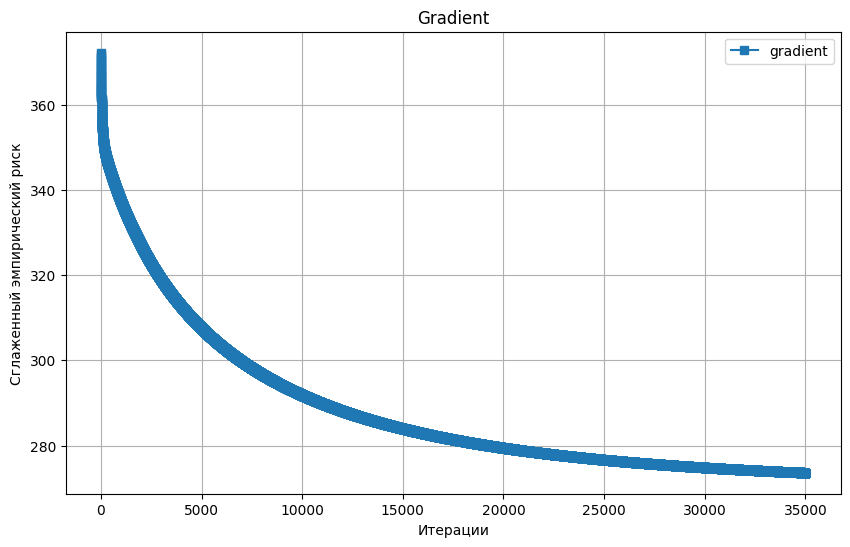

In [90]:
import matplotlib.pyplot as plt

grad_risks = linear_clf.get_emprical_risks()

plt.figure(figsize=(10, 6))
plt.plot(range(len(grad_risks)), grad_risks, label="gradient", marker='s')
plt.title("Gradient")
plt.xlabel("Итерации")
plt.ylabel("Сглаженный эмпирический риск")
plt.legend()
plt.grid()
plt.show()

In [22]:
svm_clf = SVM(kernel=Kernel.rbf, C=1.2053478705803684, max_iter=svm_max_iter)

In [ ]:
svm_clf.fit(X_train.values, y_train.values, X_test=X_test.values, y_test=y_test.values)
svm_risk = svm_clf.get_emprical_risks()

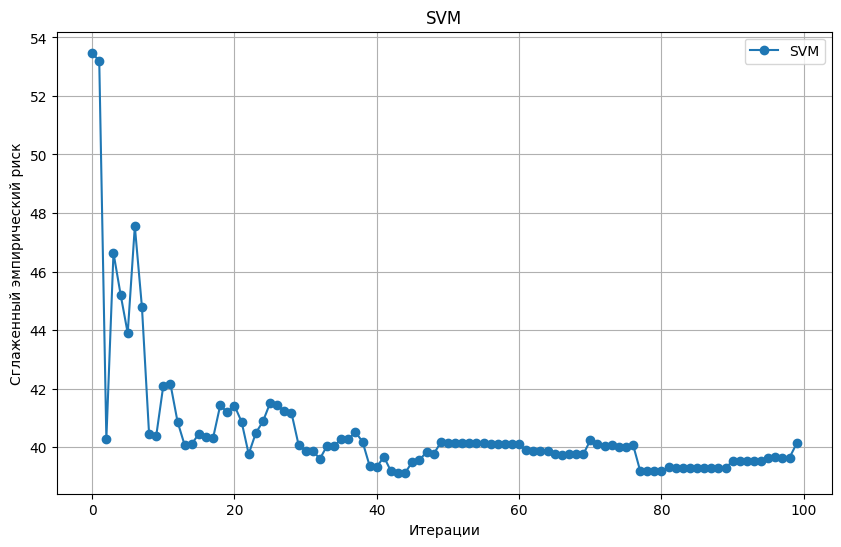

In [314]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(svm_risk)), svm_risk, label="SVM", marker='o')
plt.title("SVM")
plt.xlabel("Итерации")
plt.ylabel("Сглаженный эмпирический риск")
plt.legend()
plt.grid()
plt.show()

### Кривая обучения с целевой функцией

Переберем 5 вариантов разбиения и построим графики для них

In [23]:
from tqdm import tqdm

def collect_data(model, X, y):
    result = []
    
    seeds = [1, 2, 3, 4, 5]
    for seed in tqdm(seeds):
        X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=seed)
        normalize(X_train_, X_test_)
        
        model.fit(X_train_.values, y_train_.values, X_test=X_test_.values, y_test=y_test_.values)
        result.append(model.get_accuracies())
    
    return result 

#### Линейный классификатор

In [24]:
linear_acc = collect_data(linear_clf, X, y)

100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


In [41]:
linear_mean = np.mean(linear_acc, axis=0)
linear_std = np.std(linear_acc, axis=0)
linear_confidence_delta = 2.776 * linear_std / np.sqrt(769)

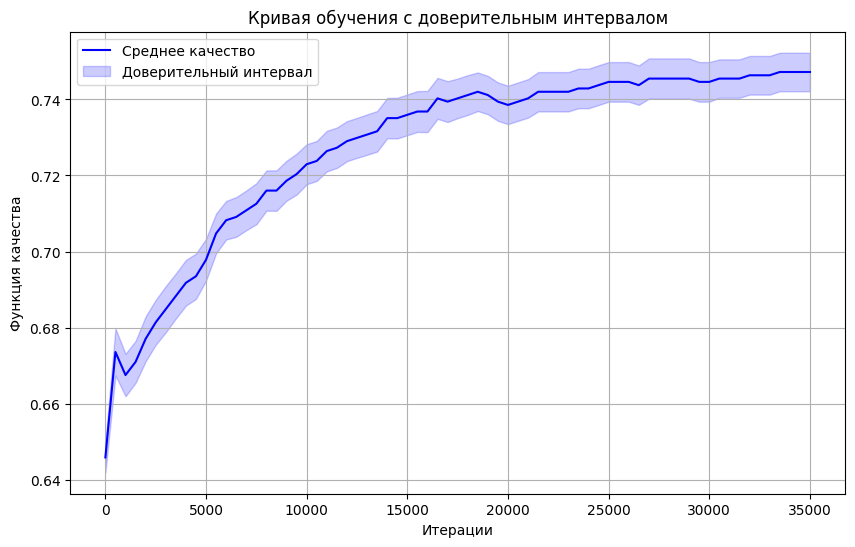

In [42]:
import matplotlib.pyplot as plt 

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(0, linear_max_iter + 1, 500), linear_mean, label="Среднее качество", color="blue")

# Добавление доверительных интервалов
plt.fill_between(range(0, linear_max_iter + 1, 500),
                 linear_mean - linear_confidence_delta, 
                 linear_mean + linear_confidence_delta,
                 color="blue", alpha=0.2, label="Доверительный интервал")

# Настройка графика
plt.xlabel("Итерации")
plt.ylabel("Функция качества")
plt.title("Кривая обучения с доверительным интервалом")
plt.legend()
plt.grid()
plt.show()

#### Метод опорных векторов

In [27]:
svm_clf = SVM(kernel=Kernel.rbf, C=1.2053478705803684, max_iter=100)

In [28]:
svm_acc = collect_data(svm_clf, X, y)

100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


In [43]:
svm_mean = np.mean(svm_acc, axis=0)
svm_std = np.std(svm_acc, axis=0)
svm_confidence_delta = 2.776 * svm_std / np.sqrt(769)

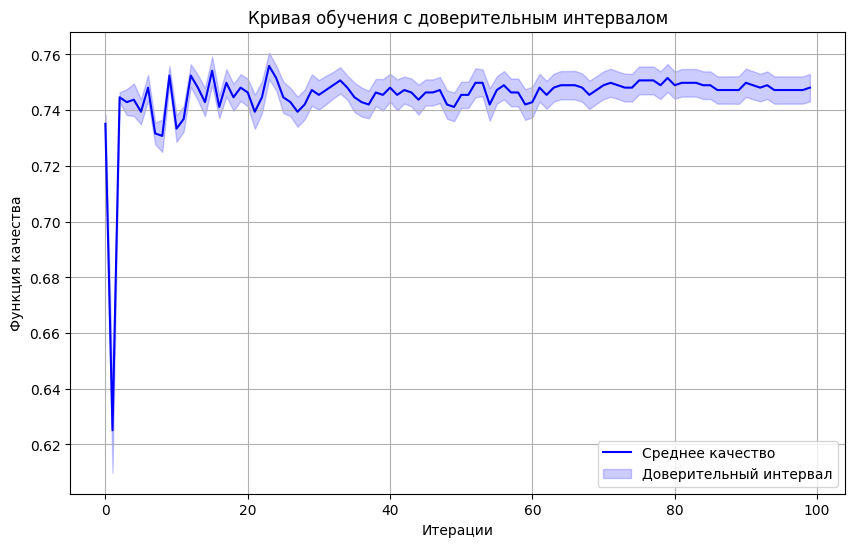

In [44]:
import matplotlib.pyplot as plt

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(len(svm_mean)), svm_mean, label="Среднее качество", color="blue")

# Добавление доверительных интервалов
plt.fill_between(range(len(svm_mean)),
                 svm_mean - svm_confidence_delta, 
                 svm_mean + svm_confidence_delta,
                 color="blue", alpha=0.2, label="Доверительный интервал")

# Настройка графика
plt.xlabel("Итерации")
plt.ylabel("Функция качества")
plt.title("Кривая обучения с доверительным интервалом")
plt.legend()
plt.grid()
plt.show()

#### Линейная регрессия

In [31]:
ridge_clf = RidgeLinearClassifier(tau=1)

In [33]:
ridge_acc = []
for seed in tqdm([1, 2, 3, 4, 5]):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=seed)
    normalize(X_train_, X_test_)
    
    ridge_clf.fit(X_train_.values, y_train_.values)
    ridge_pred = ridge_clf.predict(X_test_.values)
    ridge_acc.append(accuracy_score(ridge_pred, y_test_))

100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


In [34]:
ridge_mean = np.mean(svm_acc)
ridge_std = np.std(svm_acc)
ridge_confidence_delta = 2.776 * ridge_std / np.sqrt(769)

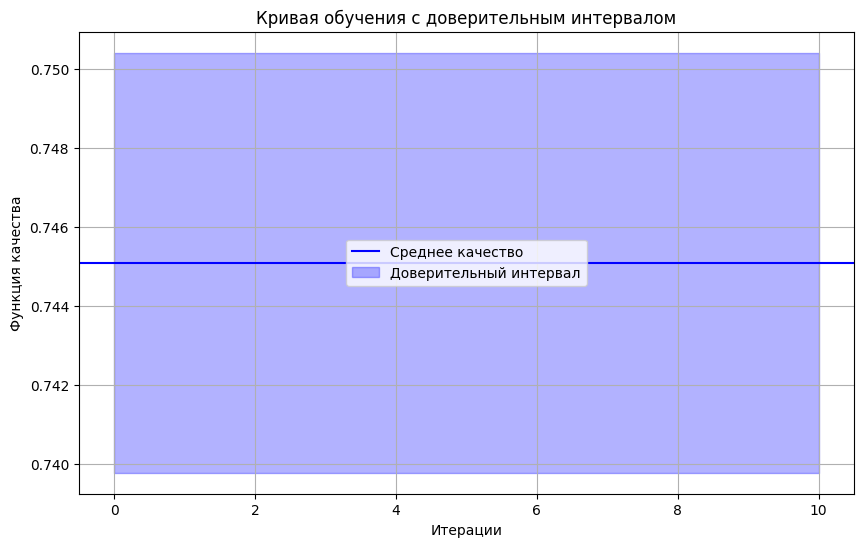

In [39]:
import matplotlib.pyplot as plt

# Построение графика
plt.figure(figsize=(10, 6))

plt.axhline(y=ridge_mean, color='blue', label="Среднее качество")

# Добавление доверительных интервалов
plt.fill_between(np.linspace(0, 10, 100), 
                 ridge_mean - ridge_confidence_delta, 
                 ridge_mean + ridge_confidence_delta, 
                 color='blue', alpha=0.3, label="Доверительный интервал")   

# Настройка графика
plt.xlabel("Итерации")
plt.ylabel("Функция качества")
plt.title("Кривая обучения с доверительным интервалом")
plt.legend()
plt.grid()
plt.show()

#### Общий график

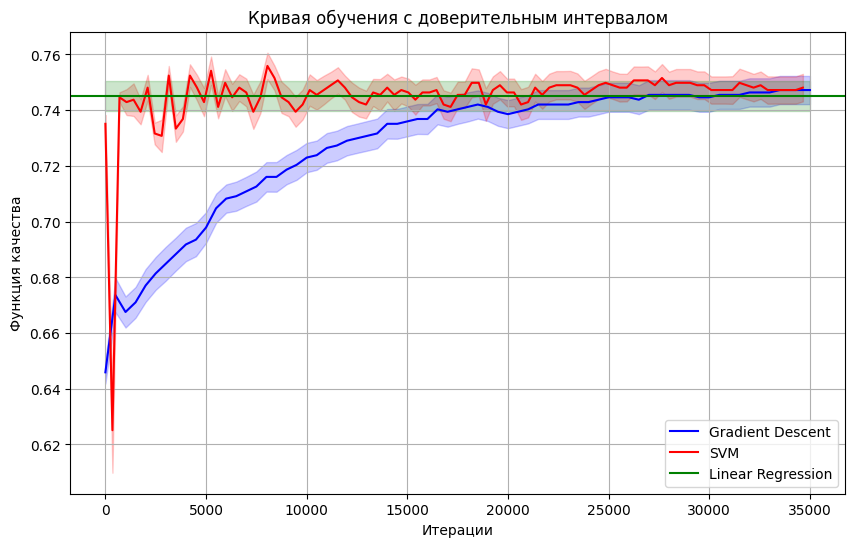

In [49]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))

# linear
plt.plot(range(0, linear_max_iter + 1, 500), linear_mean, label="Gradient Descent", color="blue")
plt.fill_between(range(0, linear_max_iter + 1, 500),
                 linear_mean - linear_confidence_delta, 
                 linear_mean + linear_confidence_delta,
                 color="blue", alpha=0.2)

# svm
plt.plot(range(0, len(svm_mean) * 350, 350), svm_mean, label="SVM", color="red")
plt.fill_between(range(0, len(svm_mean) * 350, 350),
                 svm_mean - svm_confidence_delta, 
                 svm_mean + svm_confidence_delta,
                 color="red", alpha=0.2)

# ridge
plt.axhline(y=ridge_mean, color='green', label="Linear Regression")
plt.fill_between(range(0, linear_max_iter + 1, 500), 
                 ridge_mean - ridge_confidence_delta, 
                 ridge_mean + ridge_confidence_delta, 
                 color='green', alpha=0.2)  

# Настройка графика
plt.xlabel("Итерации")
plt.ylabel("Функция качества")
plt.title("Кривая обучения с доверительным интервалом")
plt.legend()
plt.grid()
plt.show()